<a href="https://colab.research.google.com/github/RanaBan/processing_docs/blob/master/BBC_sentence_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

import spacy
nlp = spacy.load("en_core_web_sm")

import torch
import torch.nn as nn
import torch.optim as optim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Document wise sentence groups and their labels based on the summaries

In [ ]:
path = '/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/'
dirs = ['business', 'entertainment', 'politics', 'sport', 'tech']
texts, summaries = [], []
for adir in dirs:
    text_dir = os.fsencode(path+'News Articles/'+adir)
    filenames = os.listdir(text_dir)
    filenames = [str(s).split('\'')[1] for s in filenames]
    filenames = sorted(filenames)
    print(text_dir, ':', len(filenames))

    for filenm in filenames:
        thefile = path+'News Articles/'+adir+'/'+filenm

        with open(thefile, 'rb') as fp:
            temp = fp.readlines()
            texts.append(''.join([t.decode('ISO-8859-1') for t in temp]))
#   =================================================
    summ_dir = os.fsencode(path+'Summaries/'+adir)
    filenames = os.listdir(summ_dir)
    filenames = [str(s).split('\'')[1] for s in filenames]
    filenames = sorted(filenames)
    print(summ_dir, ':', len(filenames))

    for filenm in filenames:
        thefile = path+'Summaries/'+adir+'/'+filenm
        with open(thefile, 'rb') as fp:
            temp = fp.readlines()
            summaries.append(''.join([t.decode('ISO-8859-1') for t in temp]))

b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/News Articles/business' : 510
b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/Summaries/business' : 510
b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/News Articles/entertainment' : 386
b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/Summaries/entertainment' : 386
b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/News Articles/politics' : 417
b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/Summaries/politics' : 417
b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/News Articles/sport' : 511
b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/Summaries/sport' : 511
b'/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/News Articles/tech' : 401
b'/conte

In [ ]:
def treat_num(s):
    if '.' in str(s.group(0)):
        return re.sub('\.', '_', str(s.group(0)))
    else:
        return re.sub(',', '', str(s.group(0)))

document_wise_sentences, summary_sentences, labels = [], [], []
for text, summ in tqdm(zip(texts, summaries)):
    text = re.sub('\n+', '. ', text)
    text = re.sub('\.\.', '.', text)
    text = re.sub(r'[^0-9a-zA-Z\.]+', ' ', text)
    text = re.sub(r'[0-9]+\.[0-9]+', treat_num, text)
    temp_sentences = [re.sub('\.', '', s).strip() for s in sent_tokenize(text)]
    temp_sentences = [s for s in temp_sentences if s]

    document_wise_sentences.append(temp_sentences)

    summ = re.sub(r'[^0-9a-zA-Z\.]+', ' ', summ)
    summ = re.sub(r'[0-9]+\.[0-9]+', treat_num, summ)
    summ = re.sub(r'\.', '. ', summ)

    temp_summ_sentences = [re.sub('\.', '', s).strip() for s in sent_tokenize(summ)]
    summary_sentences.append(temp_summ_sentences)
    labeling = lambda s : 1 if s.strip() in temp_summ_sentences else 0
#     summary_sentences_in_text = [labeling(s) for s in sent_tokenize(summ)]
    labels.append([labeling(s) for s in temp_sentences])

2225it [00:02, 923.27it/s] 


# Dataset for the predictive modeling

In [ ]:
document_wise_sent_count = [len(document) for document in document_wise_sentences]
words_per_sentences = []
for document in document_wise_sentences:
  for sentence in document:
    words_per_sentences.append(len(word_tokenize(sentence)))

In [ ]:
print('number of sentences in the whole dataset:', len(words_per_sentences))

number of sentences in the whole dataset: 43538


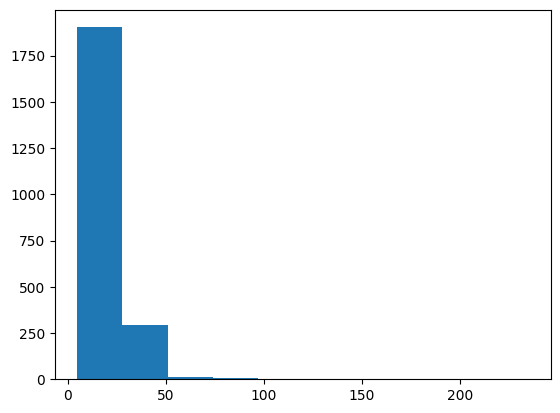

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(document_wise_sent_count)
plt.show()

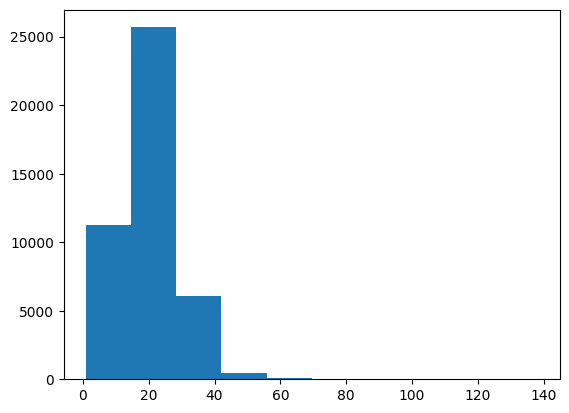

In [ ]:
plt.hist(words_per_sentences)
plt.show()

In [ ]:
max_sents = 25
max_tokens = 20

In [ ]:
# Revised documents and labels
# MAXIMUM 25 SENTENCES PER DOCUMENT IS ALLOWED
document_wise_sentences = [doc[:min(len(doc), max_sents)] for doc in document_wise_sentences]
document_wise_sent_count = [len(document) for document in document_wise_sentences]

In [ ]:
for d in range(len(document_wise_sent_count)):
  if document_wise_sent_count[d] is None:
    print(d)

In [ ]:
labels = [l[:c] for l, c in zip(labels, document_wise_sent_count)]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [ ]:
first_labels = torch.zeros((len(labels), max_sents))
# second_labels = torch.zeros((len(labels), max_sents))

for i, t in enumerate(labels):
  l = min(len(t), max_sents)
  for j, a_label in enumerate(torch.Tensor(t[:l])):
    first_labels[i][j] = a_label #[:max_sents] # LABELS FOR 25 SENTENCES
    # second_labels[i][j] = a_label

In [ ]:
first_labels[:2]

tensor([[0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
def clean(text, title=True):
    # new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',text)

    # apostrophes
    text = re.sub("'s", '', text)

    # multiple white-space
    text = re.sub('  +', ' ', text)

    # references to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    # html/xml tags
    text = re.sub('<[^<]+>', "",text)

    # url
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

    # Only alpha-numeric allowed
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text
######### Tokenize #########
def tokenize(text):
    text = clean(text)
    text = " ".join([tok.lemma_.strip() for tok in nlp(text)]) ## LEMMATIZED
    return [tok.text for tok in nlp.tokenizer(text)]
######### TOKEN TO INDEX DICTIONARY #########
def token_to_index(sentences):
    tok2indx = {} # {'<sos>':1, '<eos>':2}
    for doc in tqdm(sentences):
#         tokenized = tokenize(''.join(doc))
        tokenized = tokenize(clean(doc))
        for tok in tokenized:
            if tok not in tok2indx.keys():
                tok2indx[tok] = len(tok2indx)+1
    tok2indx['unk'] = 0
    return tok2indx

dataset_sentences = []
for s in document_wise_sentences:
  dataset_sentences.extend(s)
tok2indx = token_to_index(dataset_sentences)
indx2tok = {v: k for k, v in tok2indx.items()}

100%|██████████| 39077/39077 [05:11<00:00, 125.60it/s]


In [ ]:
def build_vocab_and_encoding(doc_list, tok2indx):
    encoded_documents = []
    for sentences in tqdm(doc_list):
        enc_doc = []
#         sentences = sent_tokenize(doc)
#         print(len(sentences))##
        for s in range(max_sents):
            encoded_sent = torch.zeros(max_tokens, dtype=torch.int32)
            ## EACH SENTENCE IS REPRESENTED WITH 15 TOKEN IDs
            if s<len(sentences):
                sent = sentences[s]
#                 print(sent)##
                tokenized = tokenize(sent)
#                 print(len(tokenized))##
                length = min(max_tokens, len(tokenized))
#                 encoded_sent[0] = tok2indx['<sos>']
                for i in range(length):                              #(1, length+1):
                    encoded_sent[i] = tok2indx[tokenized[i]]
            enc_doc.append(encoded_sent)
#         print(len(enc_doc))
        encoded_documents.append(torch.cat(enc_doc))
#         print(encoded_documents[-1].shape)

    return torch.stack(encoded_documents)
encoded_documents = build_vocab_and_encoding(document_wise_sentences, tok2indx)

100%|██████████| 2225/2225 [05:05<00:00,  7.28it/s]


In [ ]:
encoded_documents[0][:max_tokens*document_wise_sent_count[0]]
# torch.zeros(max_tokens, dtype=torch.int32)

tensor([  1,   2,   3,   4,   5,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   7,   6,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  15,  24,  21,  29,
         30,  31,  32,  33,  34,  21,  35,  36,  37,  38,  39,  25,   2,  34,
         40,  41,  42,  43,  12,  46,  47,  48,   2,  49,  50,  15,  51,  52,
         25,  53,  54,   0,   0,   0,   0,   0,   0,   0,  55,   6,  31,  56,
         57,  33,  58,  59,  30,  60,  61,   6,  62,   8,   5,  63,  44,  64,
         65,  20,   4,   5,  46,  67,  68,  69,  70,  32,  71,  72,  34,  73,
         74,  38,   0,   0,   0,   0,   0,   0,  75,  55,  71,  42,  76,  66,
         77,  77,  78,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         70,  80,  81,  82,  83,  37,  21,  47,  48,   6,  31,  84,  85,  37,
         21,  86,  22,  48,   0,   0,  87,  21,  88,  46,  66,  89,  90,   6,
         91,  92,  93,  49,  72,  67,  21,  94,  34,  95,  42,  

# The Bipertite graph based encoder-decoder model

In [ ]:
# Pytorch geometric for graph
!pip install --quiet torch_geometric
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 13.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
def build_graph(encoded_documents=encoded_documents,
                document_wise_sent_count=document_wise_sent_count,
                max_tokens=max_tokens):
    graphs = []
    for i, doc in tqdm(enumerate(encoded_documents)):
        src, dst = [], []
#         edg = []
        sent_tokens = torch.reshape(doc[:max_tokens*document_wise_sent_count[i]],\
                                 (document_wise_sent_count[i], max_tokens))


        word_tokens = []
        for token in doc[:max_tokens*document_wise_sent_count[i]]:
          if token not in word_tokens:
            word_tokens.append(int(token))

        token_id = {} # will have {key:token_no_given_by_tokenization, value:serial_of_the_token_in_that_document}
        for id, token in enumerate(word_tokens):
          token_id[token] = id+1
        id+=1
        sent_ids = [id+k for k in range(document_wise_sent_count[i])]

        for s_id, sent in zip(sent_ids, sent_tokens):
            for j, token in enumerate(sent):
                src.append(token_id[int(token)]) #word)
                dst.append(s_id)
        # n tokens in token_id and m sentences in sent_ids store integers 1 to n and n+1 to m representing tokens and sentences

        edge_index = torch.tensor([src, dst], dtype=torch.long)
        x = torch.tensor(encoded_documents[i][:max_tokens*document_wise_sent_count[i]], dtype=torch.float)
        # x = torch.tensor(word_tokens, dtype=torch.float)
        graphs.append(Data(x=x, edge_index=edge_index, y=[first_labels[i]],#, second_labels[i]],\
#                            edge_attr=edg,
                           sent_count=document_wise_sent_count[i]))
    return graphs
graphs = build_graph()

0it [00:00, ?it/s]<ipython-input-19-6551e2f74a6b>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(encoded_documents[i][:max_tokens*document_wise_sent_count[i]], dtype=torch.float)
2225it [05:13,  7.11it/s]


In [ ]:
for g in range(len(graphs)):
  if graphs[g].sent_count is None:
    print(g)

In [ ]:
import random
# graphs1 = graphs
random.shuffle(graphs)

In [ ]:
train_length = int(len(document_wise_sent_count)*0.8)
val_length = int(len(document_wise_sent_count)*0.1)

train_data, validate_data, test_data = graphs[:train_length],\
graphs[train_length:train_length+val_length], graphs[train_length+val_length:]

In [ ]:
import torch.nn.functional as F
!pip install -q pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 53.9 MB/s eta 0:00:00


In [ ]:
BATCH_SIZE = 1
input_dim = len(tok2indx)   # size of the vocabulary 45085
emb_dim = 128               # Embedding of each word
hid_dim = 128               # The dimention of each hiddenstate comming out from a time step
n_layers = 5                # LSTM layers
dropout = 0.5
num_node_features = emb_dim*2

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim, device=device)
        self.rnn = nn.LSTM(emb_dim, self.hid_dim, self.n_layers, bidirectional=True, dropout = dropout,\
                           batch_first=True, device=device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):

        embedded = self.embedding(X).to(device)
        embedded = self.dropout(embedded)

        outputs, _ = self.rnn(embedded)
        outputs = torch.relu(outputs)

        return outputs

In [ ]:
# enc = Encoder()
# output = enc(torch.unsqueeze(train_data[0].x, 0).to(torch.int64).to(device))
print(output.shape)
# torch.reshape(x, (sc, max_tokens, emb_dim*2))
print(torch.reshape(output, (train_data[0].sent_count, max_tokens, emb_dim*2)).shape)

torch.Size([1, 220, 256])
torch.Size([11, 20, 256])


In [ ]:
train_dl = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_dl = DataLoader(validate_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_dl = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def sent_class_loss_function(predictions, y, sent_count):
    # losses = torch.zeros(len(y))
    loss = nn.BCELoss()
    predictions = predictions.float()
    y = y.float()
    l = loss(predictions[:sent_count[0]], y[:sent_count[0]])
    return l

class GCN_Model(pl.LightningModule):
    def __init__(self, bias=True):
        super().__init__()
        self.encoder = Encoder()
        self.conv1 = GCNConv(num_node_features, 128)
        self.conv2 = GCNConv(128, 64)

        # self.dropout = nn.Dropout(dropout)
        self.loss_fun = nn.BCELoss()
        self.fc_impact1 = nn.Linear(64, 16)
        # self.fc_location1 = nn.Linear(64, 16)

        self.fc_impact2 = nn.Linear(16, 25)
        # self.fc_location2 = nn.Linear(16, 25)

    def forward(self, X, imp_y=None, sc=None): #loc_y=None,
#         x, edge_index, edge_attr = X
        x, edge_index = X
        ### Encoder ###
        x = torch.unsqueeze(x, 0)
        x = self.encoder(x.to(torch.int64))
        x = F.dropout(x, p=0.5, training=self.training)

        x = x.squeeze()
#         x = torch.reshape(x, (max_sents, max_tokens, emb_dim*2))
        x = torch.reshape(x, (sc, max_tokens, emb_dim*2)) # sc is sentence count
#         x = x[:sc]
        temp = torch.mean(x, 1)    # sentence wise mean
        x = torch.cat((temp, torch.reshape(x, (x.shape[0]*max_tokens, emb_dim*2))), 0)
                       # sent emb followed by word emb

        ### ------- ###
        x = self.conv1(x, edge_index)#, edge_weight=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv2(x, edge_index)#, edge_weight=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = torch.mean(x, 0)

        imp_x = F.elu(self.fc_impact1(x))
        imp_x = F.dropout(imp_x, p=0.5, training=self.training)
        impact_pred = F.sigmoid(self.fc_impact2(imp_x))

        # loc_x = F.elu(self.fc_location1(x))
        # loc_x = F.dropout(loc_x, p=0.5, training=self.training)
        # location_pred = F.sigmoid(self.fc_location2(loc_x))

        predictions = impact_pred #, location_pred)

        if imp_y is not None:
          imp_loss = sent_class_loss_function(impact_pred, imp_y, sc)
          # loc_loss = sent_class_loss_function(location_pred, loc_y, sc)

          # loss = (imp_loss + loc_loss)/2
          loss = imp_loss
          return loss, predictions
        return predictions

    def training_step(self, batch, batch_idx):
        x = (batch.x, batch.edge_index)#, batch.edge_attr)
        imp_y = batch.y[0]
        # loc_y = batch.y[1]
        sc = batch.sent_count #batch.y[2]
        loss, pred_classes = self(x, imp_y, sc) #loc_y,

        self.log('train_loss', loss, prog_bar = True, logger = True)
        return loss

    def validation_step(self, batch, batch_idx):
        # print(batch.y)
        x = (batch.x, batch.edge_index)#, batch.edge_attr) # batch.kwargs['sent_count']
        imp_y = batch.y[0]
        # loc_y = batch.y[1]
        sc = batch.sent_count #batch.y[2]
        loss, pred_classes = self(x, imp_y, sc) #loc_y,

        self.log('val_loss', loss, prog_bar = True, logger = True)
        return loss

    def test_step(self, batch, batch_idx):
        x = (batch.x, batch.edge_index)#, batch.edge_attr)
        imp_y = batch.y[0]
        # loc_y = batch.y[1]
        sc = batch.sent_count #batch.y[2]
        loss, pred_classes = self(x, imp_y, sc) #loc_y,

        self.log('val_loss', loss, prog_bar = True, logger = True)
        return loss, pred_classes

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr = 0.001, weight_decay = 0.001)

In [ ]:
model = GCN_Model()

checkpoint_callback = ModelCheckpoint(
    dirpath = path+'BBC_model_instances',
    filename = path+'best-checkpoint-BBCdata',
    save_top_k = 1,
    verbose = True,
    monitor = 'val_loss',
    mode = 'min'
)

logger = TensorBoardLogger('model_logs_word2sent', name = 'GCN-model-word2sent')

trainer = pl.Trainer(logger = logger, callbacks = checkpoint_callback, max_epochs = 30, accelerator="auto")#gpus = 1)#, progress_bar_refresh_rate = 20)

# train_dataset = MyDataset(train_x, train_y)
# val_dataset = MyDataset(validate_x, validate_y)

trainer.fit(model, train_dl, val_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params
---------------------------------------
0 | encoder    | Encoder | 4.3 M 
1 | conv1      | GCNConv | 32.9 K
2 | conv2      | GCNConv | 8.3 K 
3 | loss_fun   | BCELoss | 0     
4 | fc_impact1 | Linear  | 1.0 K 
5 | fc_impact2 | Linear  | 425   
---------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.524    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 500. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 340. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 400. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 380. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 240. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous coll

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 3560: 'val_loss' reached 0.62716 (best 0.62716), saving model to '/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/best-checkpoint-BBCdata-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 5340: 'val_loss' reached 0.62577 (best 0.62577), saving model to '/content/drive/MyDrive/Research/GridSearch_GCN_on_DisasterData/BBC News Summary/best-checkpoint-BBCdata-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 7120: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 8900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 10680: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 12460: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 14240: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 16020: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 17800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 19580: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 21360: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 23140: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 24920: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 26700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 28480: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 30260: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 32040: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 33820: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 35600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 37380: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 39160: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 40940: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 42720: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 44500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 46280: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 48060: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 49840: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 51620: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 53400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 55180: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 56960: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 58740: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 60520: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 62300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 64080: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 65860: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 67640: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 69420: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 71200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 72980: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 74760: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 76540: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 78320: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 80100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 81880: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 83660: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 85440: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 87220: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 89000: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
%load_ext tensorboard
%tensorboard --logdir 'model_logs'

In [ ]:
model.freeze()
trainer.test(model, test_dl)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 140. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.0196049213409424     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.0196049213409424}]

In [ ]:
device = torch.device('cpu')
true_imp_y, pred_imp_y, sent_counts = [], [], []#, [] true_loc_y, pred_loc_y,, []
with torch.no_grad():
    for batch in tqdm(test_dl):#dataloader:
        # x = (batch.x.to(device), batch.edge_index.to(device)#, batch.edge_attr.to(device))
        x = (batch.x, batch.edge_index)
        imp_y = batch.y[0].to(device)
        # loc_y = batch.y[1].to(device)
        sc = batch.sent_count #batch.y[2]

        y_hat = model(X=x, sc=sc)

        true_imp_y.append(imp_y)
        # true_loc_y.append(loc_y)
        pred_imp_y.append(y_hat)
        # pred_loc_y.append(y_hat[1])
        # docs.append(X[0])
        sent_counts.append(sc)

  0%|          | 0/223 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 223/223 [00:09<00:00, 24.72it/s]


In [ ]:
def rounding(pred, threshold = 0.5):
  prd = torch.zeros(pred.shape)
  for j, a in enumerate(pred):
    if a>threshold:
      prd[j] = 1
    else:
      prd[j] = 0
  return prd

In [ ]:
rounding(torch.Tensor(pred_imp_y[0]))
# len(pred_imp_y)

tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0.])

In [ ]:
def dice_coefficient(p, y):
    smoothing = 0.0001
    return ((2*torch.sum(torch.abs(p * y)))+smoothing)/(torch.sum(torch.abs(p))+torch.sum(torch.abs(y))+smoothing)

In [ ]:
imp_magnitude = torch.zeros(len(true_imp_y)-1)
count = 0
for i in range(len(true_imp_y)-1):
    imp_magnitude[i] = dice_coefficient(pred_imp_y[i][:sent_counts[i]], true_imp_y[i][:sent_counts[i]])

print('Dice score: ', torch.mean(imp_magnitude))

tensor(0.4533)


In [ ]:
class_correct_predictions = np.zeros(len(true_imp_y))
for i in range(len(true_imp_y)):

    k = true_imp_y[i][:sent_counts[i]] + rounding(pred_imp_y[i], 0.7)[:sent_counts[i]]
    class_correct_predictions[i] = sum([1 if k[j] in [0, 2] else 0 for j in range(len(k))])/sent_counts[i]
class_correct_predictions = np.array(class_correct_predictions)
print('Accuracy: ', np.mean(class_correct_predictions))

0.6425812303218071

In [ ]:
from sklearn.metrics import f1_score
# loc = np.zeros((len(pred_loc_y), len(pred_loc_y[0])))
imp = np.zeros((len(pred_imp_y), len(pred_imp_y[0])))
for i in range(len(pred_imp_y)):
  # loc[i] = np.array(rounding(pred_loc_y[i], 0.45))
  imp[i] = np.array(rounding(pred_imp_y[i], 0.45))

# loc_y_np = np.zeros((len(true_loc_y), len(true_loc_y[0])))
imp_y_np = np.zeros((len(true_imp_y), len(true_imp_y[0])))
for i in range(len(pred_imp_y)):
  # loc_y_np[i] = np.array(true_loc_y[i])
  imp_y_np[i] = np.array(true_imp_y[i])

# print('Location:', f1_score(loc_y_np, np.round(loc), average='samples'))
print('F-measure score: ', f1_score(imp_y_np, np.round(imp), average='samples'))

Impact: 0.33766753334253924
